In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pprint import pprint

from typing import Union
from typing import List
from typing import Tuple

%matplotlib inline

# Автоматизация поиска пиков в данных о количестве покупок в различных MCC

## Введение

Данная работа ставит своей целью автоматизацию поиска пиков в данных о количестве покупок в различных MCC и группах MCC. Для начала приведем определение терминов MCC и группа MCC:

**MCC код** (англ. Merchant Category Code — буквально «код категории продавца») — представляет собой 4-значный номер, классифицирующий вид деятельности торговой точки в операции оплаты по банковским картам [1].

**Группа MCC** - верхнеуровневое объединение нескольких MCC. Например, "Профессиональные услуги", в которые входят MCC: 8021 (Стоматологи, ортодонты), 8111 (Адвокаты, юридические услуги), 8249 (Профессиональные школы и училища) и т.д. [2]

MCC позволяет определить род деятельности продавца. Данные о количестве покупок в различных категориях позволяют изучить особенности поведения потребителей различных видов товаров. Проект, который стал основой для данной работы, имел цель определять значительные изменения в количестве покупок во время различных праздников. Такие изменения можно искать вручную отсматривая каждый временной ряд, но так как всего MCC насчитывается несколько сотен, это занимает много времени. Также, в ручном анализе присутствует человеческий фактор - разные аналитики по разному могут оценить один и тот же пик. Ещё, чем дольше временной ряд растянут во времени, тем сложнее "на глаз" увидеть некоторые пики. 

Для того, чтобы увеличить точность и скорость нахождния пиков было принято решение автоматизировать процесс нахождения пиков. Алгоритм должен выявлять самые значительные изменения и добавлять их в базу. После этого данные из визализируются с помощью BI программы и аналитик может изучать пики, которые нашел алгоритм.

В данной работые были использованы данные о количестве танзакций пользователей за 2019 год для одной платежной системы в 104 MCC, которые объединены в 20 групп. Так как данные о транзакциях являются конфедециальными, количественные показатели были изменены и не соответствуют реальным, а коды МСС были замаскированы.

Процесс работы с данными состоит из трех частей: 
- Трансформация данных во временные ряды, 
- Подбор весов для поиска пиков, 
- Визуализация найденных пиков.  

За основу алгоритма для поиска пиков был взят алгоритм кумулятивной суммы [3][4].

## Функции

Поиск пиков производится с помощью алгоритма поиска кумулятивной суммы (CumSum). Данный алгоритм позволяет найти не только сам пик, но так же начало и конец изменения этого пика. Этот алгоритм был выбран, так как он дает меньше ложных срабатываний, чем алгоритм срабатывания по пороговому значению и не обладает задержкой в обнаружении пика, как у алгоритмов с потоковым окном.

У CumSum есть два параметра, которые настраивают работу алгоритма: порог (threshold) и дрифт (drift). Порог определяет амплитуду изменения, которое должно произойти чтобы алгоритм определил пик, а дрифт - это компенсатор, который позволяет алгоритму игнорировать шум. Чем меньше порог и дрифт, тем чаще срабатывает алгоритм и наоборот.

У алгоритма есть две доп функции: _plot() и _merge(). 

_plot() - визуализирует пики на временном ряду. 

_merge() - позволяет объеденять несколько срабатываний рядом друг с другом. Эта функция была добавлена мной для обработки ситуаций, когда для одного пика происходило два срабатывания алгоритма, одно на рост значений, другое на уменьшение. Так как в данном слуае одна точка несет столько же информации, сколько и две, дополнительные точки являются шумом и объединяются. 

In [4]:
def detect_cusum(x, threshold=1, drift=0, ending=False, 
                 show=True, ax=None, merge=False, merge_width=3):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    merge: bool, optional (default = False)
        True (1) merges points if they are within the merge width, False (0) doesn't merge.
    merge_width: int, optional, (default = 3)
        sets the window for merging the points

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]
        
    if merge:
        ta, tai, taf, amp = _merge(ta, tai, taf, amp, merge_width)

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()
        
def _merge(
    ta: List[int], 
    tai: List[int], 
    taf: List[int], 
    amp: List[float],
    width: int
):
    "Merge points in the that are close together."
    if len(ta) == 0:
        return ta, tai, taf, amp

    new_ta = [ta[0]]
    new_tai = [tai[0]]
    new_taf = [taf[0]]
    new_amp = [amp[0]]
    for i in range(1, len(ta)):
        diff = ta[i] - ta[i-1]
        if diff > width:
            new_ta.append(ta[i])
            new_tai.append(tai[i])
            new_taf.append(taf[i])
            new_amp.append(amp[i])
    
    return new_ta, new_tai, new_taf, new_amp
        

Данные представлены в виде датафрейма, поэтому необходим метод, который будет извлекать временной ряд для каждой MCC. Метод get_timeseries() извлекает временные ряды для всех MCC одной группы для заданного временного промежутка.

In [5]:
def get_timeseries(
    df: pd.DataFrame, 
    mcc_set_one_rus: str,
    start_date: str = '0',
    end_date: str = '0'
) -> Dict[str, Tuple[List[int]]]:
    """Extracts timeseries from a given MCC group.
    
    Parameters
    ----------
    df : pd.DataFrame
        data
    mcc_set_one_rus : str
        MCC group for which timeseries must be extracted
    start_date : str, default = '0'
        start date of the timeseries
    end_date : str, default = '0'
        end date of the timeseries
        
    Returns
    -------
    Dict[str, Tuple[List[int]]]
        data in the following form:
        {
            MCC: (x, y)
            ...
        }
    """
    mccs = df[df['MCC_SET_ONE_RUS'] == mcc_set_one_rus].MCC.unique().tolist()
    result = {}
    if start_date == '0':
        start_date = df['TRAN_DATE'].min()
    if end_date == '0':
        end_date = df['TRAN_DATE'].max()
    
    for mcc in mccs:
        condition = (
            (df['MCC_SET_ONE_RUS'] == mcc_set_one_rus) 
            & (df['MCC'] == mcc)
            & (df['TRAN_DATE'] >= start_date)
            & (df['TRAN_DATE'] <= end_date)
        )
        x = np.array(df['TRAN_DATE'][condition])
        y = np.array(df['TRAN_COUNT'][condition].apply(int))
        result[mcc] = (x, y)
    
    return result

Метод visualise() визуализирует временные ряды. Есть два режима визуализации: отображение временного ряда, либо отображение найденных пиков. Ещё есть два типа группировки: визуализация отдельных MCC или визуализация всей группы MCC. 

При визуализации всей группы MCC, значения количества временных рядов всех MCC в этой группе складываются. Для построения пиков находятся медианные веса из всех весов MCC этой группы.

In [228]:
def visualise(series: dict, grouping: str, mode: str, weights: dict) -> None:
    """Visualises timeseries or peaks.
    
    Parameters
    ----------
    series : dict
        dictionary with timeseries
    grouping : str
        choose an option:
        * mcc_group - display aggregated mccs
        * mcc_sep - display each mcc in group separately
    
    mode : str
        choose an option:
        * timeseries - visualise timeseries
        * peaks - visualise peaks
    weights : dict
        weights for each mcc to visualise
        
    Returns
    -------
    Visualisaion fo the timeseries
    """
    if grouping == 'mcc_group':
        y_check = True
        for mcc in series:
            if y_check:
                y = series[mcc][1]
                y_check = False
            else:
                y += series[mcc][1]

        x = series[mcc][0]
        if mode == 'timeseries':
            _timeseries(x, y)
        elif mode == 'peaks':
            w_t, w_d = _group_weights(weights, mode='median')
            _peaks(y, w_t, w_d)
    elif grouping == 'mcc_sep':
        for mcc in series:
            y = series[mcc][1]
            x = series[mcc][0]
            if mode == 'timeseries':
                _timeseries(x, y, mcc)
            elif mode == 'peaks':
                w_t, w_d = weights[mcc]
                _peaks(y, w_t, w_d, mcc)

                
def _group_weights(weights: dict, mode: str) -> Tuple[float, float]:
    """Finds weights for MCC group from MCC's it consists of.
    """
    w_t_list = []
    w_d_list = []
    for key in weights:
        w_t_list.append(weights[key][0])
        w_d_list.append(weights[key][1])
        
    if mode == 'mean':
        w_t = np.mean(w_t_list)
        w_d = np.mean(w_d_list)
    elif mode == 'median':
        w_t = np.median(w_t_list)
        w_d = np.median(w_d_list)
    
    return w_t, w_d
                
def _timeseries(x: np.array, y: np.array, mcc: str = None) -> None:
    """Visualises timesries with a horizontal lines representing mean and median.
    """
    mean = np.mean(y)
    median = np.median(y)
    print(f"mean: {mean}")
    print(f"median: {median}")

    plt.figure(figsize=(12, 7))
    if mcc is not None:
        plt.title(f"MCC: {mcc}")
    plt.plot(x, y, label='timeseries')
    plt.hlines(mean, x.min(), x.max(), 'b', 'dashed', 'mean')
    plt.hlines(median, x.min(), x.max(), 'r', 'dashed', 'median')
    plt.legend()
    plt.show()
    

def _peaks(y: np.array, w_t: float=0.5, w_d: float = 0.5, mcc: str = None, data_print: bool = False) -> None:
    """Visualises timeseries with peaks found by CumSum algorithm.
    """
    mean = np.mean(y)
    median = np.median(y)
    if mcc is not None:
        print(f"MCC: {mcc}")
    threshold = mean * w_t
    drift = threshold * w_d
    ta, tai, taf, amp = detect_cusum(y, threshold, drift, show=True, ending=True, merge=True)
    if data_print:
        print('ta', ta)
        print('tai', tai)
        print('taf', taf)
        print('amp', amp)

Веса для каждого временного ряда подбираются автоматически с помощью метода calculate_weights(). Как стартовая точка, берется среднее значение временного ряда. Для порога (threshold) подбирается вес от среднего значения ряда. В начале этот вес равен 2. Затем алгоритм постепенно уменьшает значение веса и считает количество пиков для каждого значения. Алгоритм работает до тех пор, пока количество точек не станет больше двух. Затем, для предотвращения "взрыва", ситуации, когда CumSum дает слишком много ложных срабатываний, порог (threshold) увеличивается до тех пор, пока кол-во точек не станет меньше 5. В проекте, на основании которого сделана эта работы данные временных рядов анализировались вручную и было показано, что в среднем на каждый временной ряд приходится не больше 5 значительных пиков. Такое окно, от 2 до 5 точек, позволяет находить, только самые значимые пики во временном ряду, а также убирает все ложные срабатывания.

Для дрифта (drift) значение подбирается похожим способом. Отличие заключается в том, что для дрифта (drift) считается вес от порога (threshold), а не от среднего значения ряда. Для начальной точки берется вес 0.5 от порога (threshold). После нахождение порога (threshold), алгоритм постепенно уменьшает значение дрифта, чтобы получить больше срабатываний алгоритма.

Чтобы избежать ситуаций с бесконечным перебором весов, при изменении весов запускается счетчик, который возвращяет веса к изначальным значениям, если достигает лимита итераций.

In [281]:
def calculate_weights(y: np.array) -> Tuple[float, float]:
    """Calculates weights for a single timeseries.
    
    Parameters
    ----------
    y : np.array
        1-D array representing timeseries
        
    Returns
    -------
    Tuple[float, float]
        weights in a form (w_t, w_d)
        w_t - weight for threshold, fraction of mean
        w_d - weight of drift, fraction of threshold
    """
    mean = np.mean(y)
    w_t = 2
    w_d = 0.5
    threshold = mean * w_t
    drift = threshold * w_d
    ta = []      
    count = 0
    while len(ta) < 2:
        count += 1
        if count > 1999:
            w_t = 1
            break
        w_t *= 0.99
        threshold = mean * w_t
        drift = threshold * w_d

        ta, tai, taf, amp = detect_cusum(y, threshold, drift, show=False, ending=True, merge=True)
        
    count = 0
    w_t_save = w_t
    while len(ta) > 5:
        count += 1
        if count > 1999:
            w_t = w_t_save
            break
        w_t *= 1.01
        threshold = mean * w_t
        drift = threshold * w_d

        ta, tai, taf, amp = detect_cusum(y, threshold, drift, show=False, ending=True, merge=True)

    length = len(ta)
    count = 0
    while len(ta) < length + 1:
        count += 1
        if count > 999:
            w_d = 0.5
            break
        w_d *= 0.99
        drift = threshold * w_d

        ta, tai, taf, amp = detect_cusum(y, threshold, drift, show=False, ending=True, merge=True)
    
    return w_t, w_d

Метод find_weights() получает на вход датафрэйм, преобразует данные во временные ряды и с помощью метода calculate_weights() составляет словарь с весами для алгоритма CumSum.

In [282]:
def find_weights(
    df: pd.DataFrame,
    mcc_list: List[str], 
    start_date: str, 
    end_date: str,
    verbose: bool = False
) -> dict:
    """Automatically calculates weights for each mcc timeseries.
    
    Parameters
    ----------
    df : pd.DataFrame
        dataframe with data
    mcc_list : List[str]
        list of mcc groups for which weights must be calculated
    start_date : str
        start date of the timeseries
    end_date : str
        end date of the timeseries
    verbose : bool, default = False
        displays which MCC group and MCC is currently calculated
        
    Returns
    -------
    dict
        weights for each mcc timeseries
    """
    weights = {}

    for name in mcc_list:
        if verbose:
            print(f'MCC group: {name}')
        series = get_timeseries(df, name, start_date, end_date)
        mcc_dict = {}
        for mcc in series:
            if verbose:
                print(f'  MCC: {mcc}')
            y = series[mcc][1]
            w_t, w_d = calculate_weights(y)
            mcc_dict[mcc] = (w_t, w_d)

        weights[name] = mcc_dict
        if verbose:
            print('  Calculated')
                
    return weights

## Пример работы

Загружаем данные о количестве покупок в различных MCC.

In [283]:
df = pd.read_csv('mcc_data_masked.csv', engine='python')

Получаем список уникальных групп MCC.

In [284]:
mcc_of_interest = df.MCC_SET_ONE_RUS.unique()

Находим веса для каждого MCC.

In [285]:
weights = find_weights(df, mcc_of_interest, '2019-01-01', '2020-01-01', verbose=False)

In [286]:
pprint(weights)

{0: {0: (1.07253645041437, 0.1963555141789025),
     47: (1.4068953899991383, 0.46603267395349496),
     95: (1.98, 0.262798243762781),
     98: (1.98, 0.27634173858119254)},
 1: {1: (0.6620661766420277, 0.41308431191779327),
     3: (0.3965485131778289, 0.1963555141789025),
     7: (1.0302742348476066, 0.34472454293453886),
     8: (0.635978127638287, 0.3624901679789267),
     28: (0.5809769886199274, 0.3517238474997846),
     36: (0.8342417598664409, 0.3698501866941401),
     40: (0.6961862289848841, 0.4089534687986153),
     45: (0.8094639453566478, 0.22152399081308627),
     59: (0.9040873005329508, 0.38502157290257755),
     75: (0.675508801797804, 0.37735964360181623),
     82: (0.8013693059030813, 0.20856043996661022),
     84: (0.7394592752994531, 0.08356696750744182),
     88: (0.6296183463619041, 0.2400707282857106),
     97: (0.3965485131778289, 0.41308431191779327)},
 2: {2: (1.6358138751944613, 0.05479145278167411)},
 3: {4: (1.5872285672873105, 0.1606005372823957),
     1

Для примера визуализируем пики для случайной группы MCC. 

_Можно изменить значение параметра **mcc_group**, чтобы посмотреть, как алгоритм ищет пики для других групп MCC._

In [318]:
mcc_group = 1
series = get_timeseries(df, mcc_group)

MCC group: 1


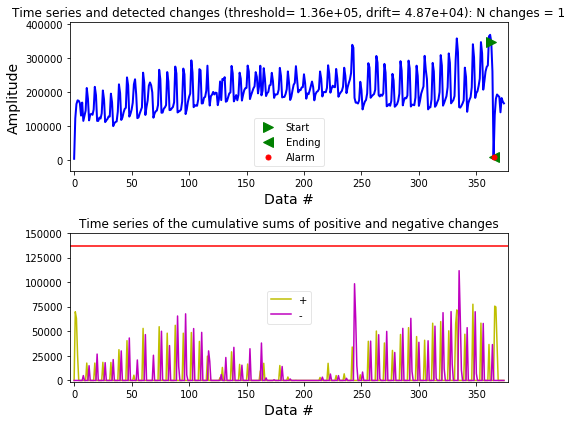

In [319]:
print(f'MCC group: {mcc_group}')
visualise(series, grouping='mcc_group', mode='peaks', weights=weights[mcc_group])

MCC: 1


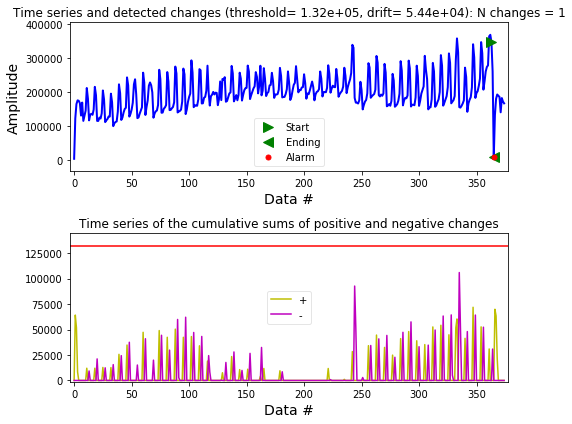

MCC: 3


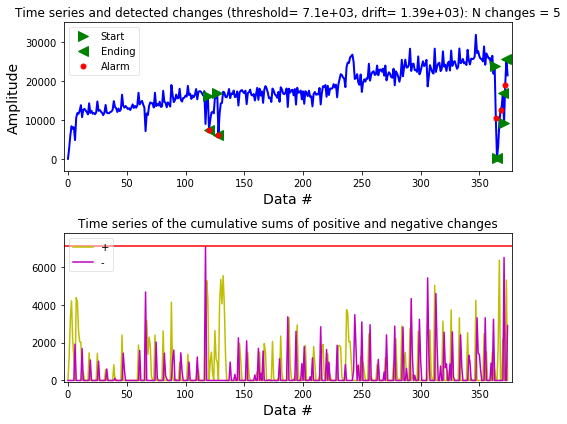

MCC: 7


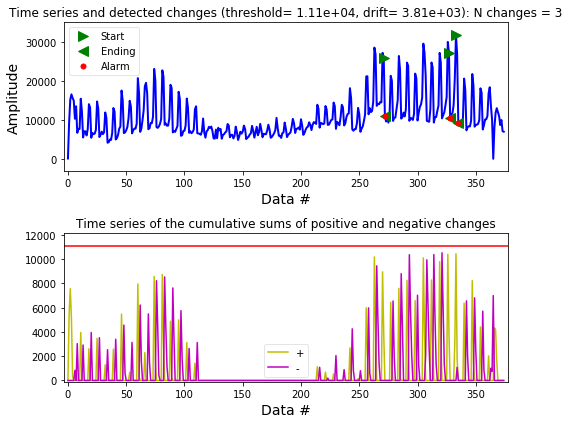

MCC: 8


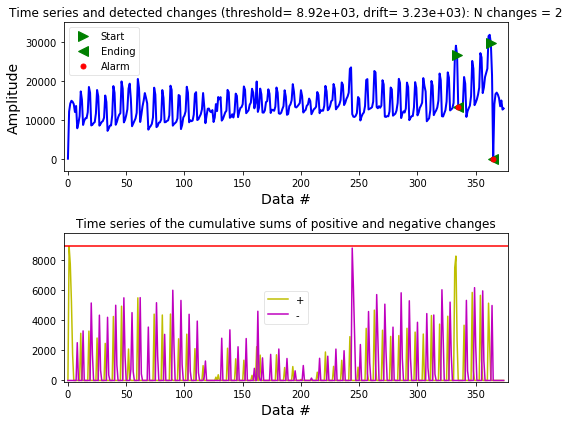

MCC: 28


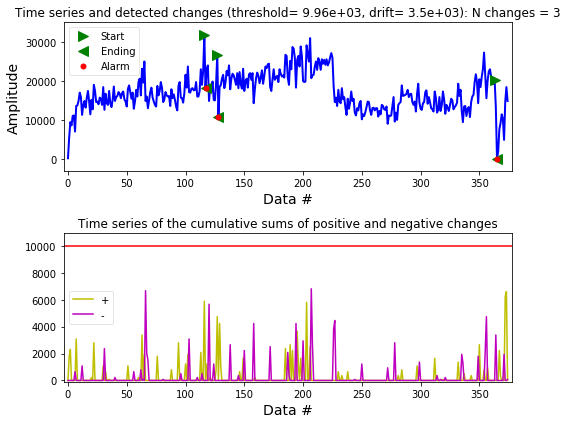

MCC: 36


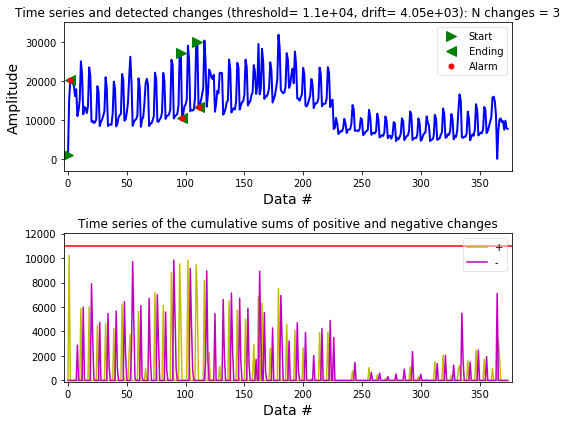

MCC: 40


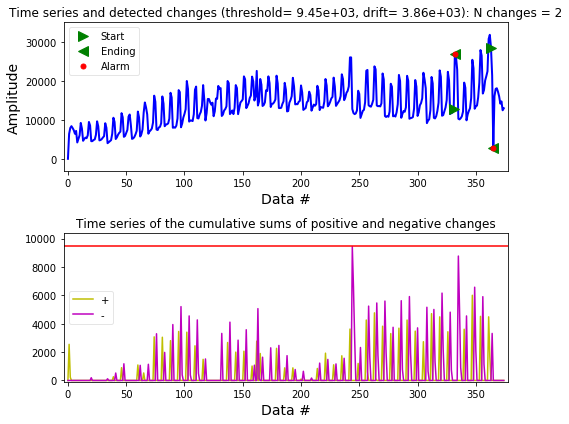

MCC: 45


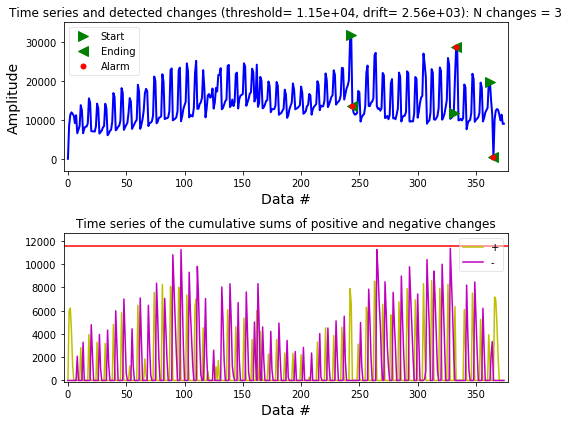

MCC: 59


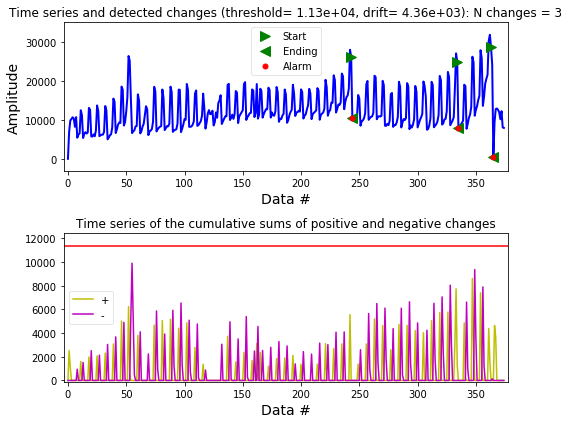

MCC: 75


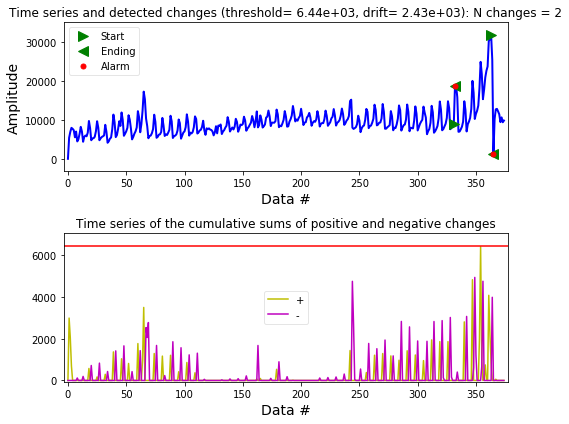

MCC: 82


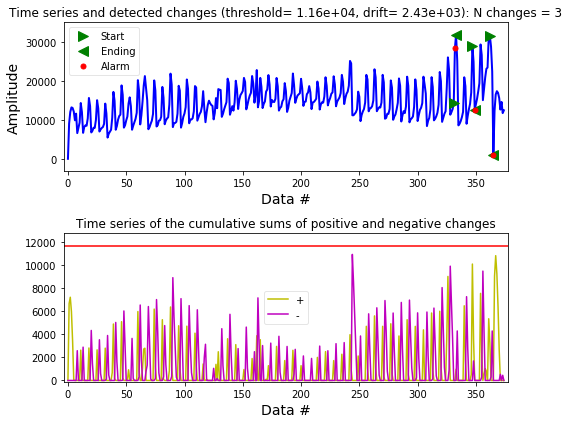

MCC: 84


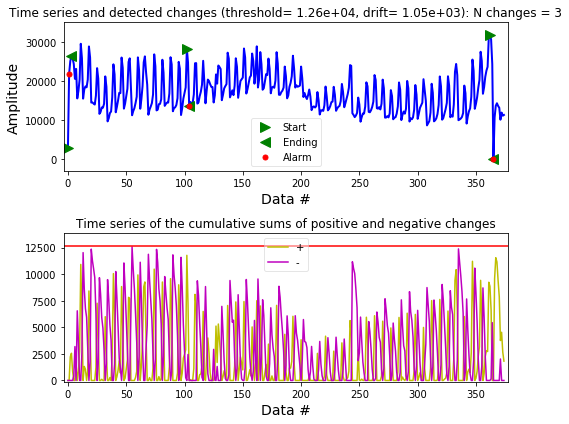

MCC: 88


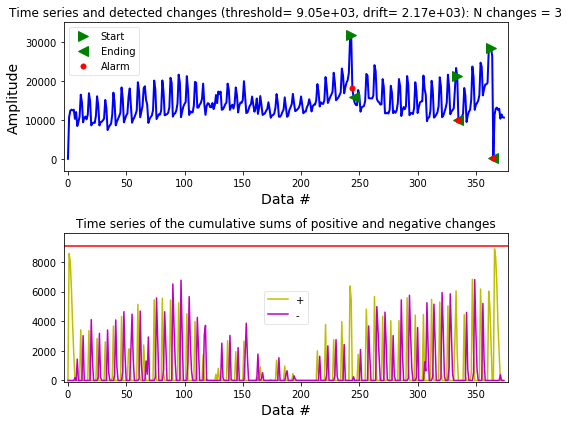

MCC: 97


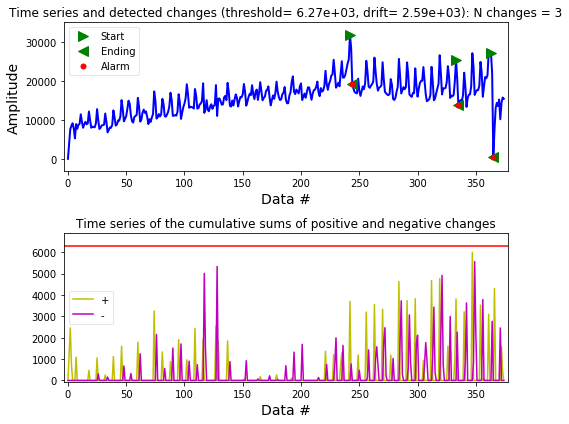

In [320]:
visualise(series, grouping='mcc_sep', mode='peaks', weights=weights[mcc_group])

## Заключение

## Источники

[1] https://ru.wikipedia.org/wiki/Merchant_Category_Code

[2] https://mcc-codes.ru/code

[3] Gustafsson (2000) Adaptive Filtering and Change Detection.

[4] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb